# Searching the Catalog via API

This guide shows methods for using Hydrosat's SpatioTemporal Asset Catalog (STAC) API to search for data that meets your criteria. Topics covered include:
- Searching by collection
- Searching by area of interest
- Searching by date range
- Searching by metadata tag

## 1. Import dependencies.

In [16]:
import json
import requests
import pystac
from pystac_client import Client
import os
import base64
import matplotlib.pyplot as plt

## 2. Connect to the STAC API with your account credentials.

#### Note: This step is optional if accessing imagery from Hydrosat's Open Data program.

Before running this next cell, you'll need to edit the `creds.json` file provided in the same directory as this notebook.

The format of the file should be:

```
{
"username":"<your_username>",
"password":"<your_password>"
}
```

Leave the quotation marks as is.

In [17]:
with open('creds.json') as f:
    creds = json.loads(f.read())

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint. You don't need to make any changes here.

In [18]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

Now you can explore the VZ-1 STAC catalog!

## 3. Define your search terms.

The catalog contains VZ-1 imagery from around the globe. Let's start with a simple search of the catalog limited only by the collection of interest and the maximum total number of items. 

Be patient! You may need to wait several seconds for the response to your query.

In [19]:
collections = ["pydms_sharpened_landsat"] # SUB THIS FOR VZ COLLECTIONS WHEN AVAILABLE

In [20]:
search = catalog.search(
    collections = collections,
    max_items=100)

items_in_collection = search.get_all_items()

print("Found " + str(len(list(items_in_collection))) + " items.")

Found 100 items.


### Searching by area of interest

We can add more criteria to ```catalog.search()``` to find data that intersects a specific location.

We'll start by defining a point geometry in California's Central Valley. This ```geom``` will be used as an input to ```catalog.search()```. Any imagery that overlaps this point will be returned.

In [21]:
point_geom = {'type': 'Point', 'coordinates': [-120.211,36.535]} # Point for Hanford, CA, USA

In [22]:
search = catalog.search(
    collections = collections,
    intersects = point_geom,
    max_items = 10
)

items_intersecting_point = search.get_all_items()

print("Found " + str(len(list(items_intersecting_point))) + " items.")

Found 10 items.


We can use any GeoJSON geometry type with ```intersects```, including a MultiPoint, LineString, MultiLineString, Polygon, or MultiPolygon. For example, we can define:

In [23]:
poly_geom = {'type': 'Polygon', 'coordinates': [[[-119.67,36.34],
                                            [-119.67,36.29],
                                            [-119.60,36.29],
                                            [-119.60,36.34],
                                            [-119.67,36.34]]]} # Polygon for Hanford, CA, USA

And repeat the search:

In [24]:
search = catalog.search(
    collections = collections,
    intersects = poly_geom,
    max_items = 10
)

items_intersecting_poly = search.get_all_items()

print("Found " + str(len(list(items_intersecting_poly))) + " items.")

Found 10 items.


Alternatively, we can search with a bounding box instead of using ```intersects```.

In [25]:
bbox = [-120.3, 36.5, -120.2, 36.6] # [lon_min, lat_min, lon_max, lat_max]

In [26]:
search = catalog.search(
    collections = collections,
    bbox = bbox,
    max_items = 10
)

items_intersecting_bbox = search.get_all_items()

print("Found " + str(len(list(items_intersecting_bbox))) + " items.")

Found 10 items.


### Searching by date range

We can also specify the start and end dates (and times) for the search. Let's request all imagery captured between August 17, 2021 and September 20, 2021 (inclusive).

In [27]:
start_date = "2021-08-17"
start_time = "T00:00:00Z"

end_date = "2021-09-20"
end_time = "T00:00:00Z"

In [28]:
search = catalog.search(
    collections = collections,
    datetime = [start_date+start_time, end_date+end_time],
    max_items = 10
)

items_in_daterange = search.get_all_items()

print("Found " + str(len(list(items_in_daterange))) + " items.")

Found 10 items.


We can include this information along with our AOI to find all items that meet both criteria.

In [31]:
search = catalog.search(
    collections = collections,
    intersects = point_geom,
    datetime = [start_date+start_time, end_date+end_time],
    max_items = 10
)

items_place_and_time = search.get_all_items()

print("Found " + str(len(list(items_place_and_time))) + " items.")

Found 4 items.


### Searching by metadata tag

Anything listed under an item's ```properties``` is also acceptable for use as a search filter. Here, we'll first explore the available ```properties```. 

In [32]:
items_place_and_time[0].properties

{'product': 'Landsat',
 'mgrs_tile': '10SGF',
 'processing:software': {'geo-pipeline': 'default', 'pydms': '1.0.0'},
 'processing:lineage': '',
 'processing:level': 'L3',
 'hydrosat:stage': 'sharpen_output',
 'hydrosat:fusion_inputs': ['t0_pair', 'hires'],
 'datetime': '2021-09-15T18:34:12.169587Z',
 'processing:prep-sharpen-fuse-version': '26.1',
 'processing:cirrus_run': 'CR_2023-05-08T23:29:31.018732',
 'processing:cirrus': True,
 'processing:geo_version': '',
 'processing:hires_tolerance_days': 15,
 'processing:output_resolution': 20,
 'processing:overwrite_outputs': True,
 'processing:public': True,
 'processing:qa_screen_opts': {'landsat': True,
  'S2': True,
  'ECO': True,
  'MCD43': True,
  'MOD21': True,
  'VNP43': True,
  'VNP21': True},
 'processing:replace': True,
 'processing:run_fusion': True,
 'processing:run_prepare': True,
 'processing:run_sharpen': True,
 'processing:pydms_common_opts': {'useDecisionTree': True,
  'lowResQualityFiles': [],
  'lowResGoodQualityFlags': 

Let's try it out. 

We'll use the ```hydrosat:data_coverage``` property to further constrain our search based on data availability. Specifically, we only want images from our AOI and within our date range that have at least 50% data coverage. To streamline our result, we'll use ```sortby``` to sort the items by increasing coverage. If we wanted to sort by decreasing coverage, we could substitute the "+" character in ```sortby``` for "-".

In [33]:
search = catalog.search(
    collections = collections,
    intersects = point_geom,
    datetime = [start_date+start_time, end_date+end_time],
    query = ["hydrosat:data_coverage>50"],
    sortby=["+properties.hydrosat:data_coverage"],
    max_items = 100
)

items_filtered_by_metadata_tag = search.get_all_items()

print("Found " + str(len(list(items_filtered_by_metadata_tag))) + " items.")

Found 3 items.


### Summary of approaches

Whether you're interested in searching for data by AOI, date range, metadata tag, or all of the above, you can use the API to find what you need.

Let's summarize the number of items we retrieved with each search above.

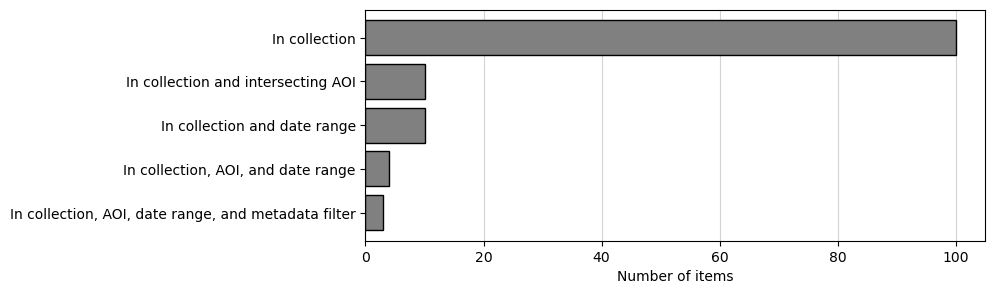

In [62]:
n_items = [len(list(i)) for i in [items_in_collection,
                                  items_intersecting_point,
                                  items_in_daterange,
                                  items_place_and_time,
                                  items_filtered_by_metadata_tag]]

plt.figure(figsize=(8,3))
plt.barh(y=range(len(n_items)),
         width=n_items[::-1],
         facecolor='gray', 
         edgecolor='black',
         zorder=2);
plt.yticks(range(len(n_items)),
          ['In collection',
          'In collection and intersecting AOI',
          'In collection and date range',
          'In collection, AOI, and date range',
          'In collection, AOI, date range, and metadata filter'][::-1]);
plt.xlabel('Number of items')
plt.grid(which='major', axis='x', color='lightgray')